In [1]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from os import path
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score
from numpy import interp
from sklearn.metrics import confusion_matrix

In [2]:
# get performance results from the model
results = pd.read_csv('./day_2048/results.csv')
results.head()

,N,nbags,exp,injuries,non-injuries,thresh,Val_AUC,Val_RE,Val_SP,Val_TP,Val_FP,Val_TN,Val_FN,Test_AUC,Test_RE,Test_SP,Test_TP,Test_FP,Test_TN,Test_FN
0,10,9,0,50,2994,0.459026,0.724415,0.64,0.638277,32,1083,1911,18,0.717829,0.54,0.731797,27,803,2191,23
1,10,9,1,50,2994,0.477397,0.740324,0.70,0.705077,35,883,2111,15,0.732953,0.60,0.788243,30,634,2360,20
2,10,9,2,50,2994,0.461639,0.721770,0.66,0.692719,33,920,2074,17,0.730855,0.58,0.765197,29,703,2291,21
3,10,9,3,50,2994,0.462360,0.739292,0.66,0.651303,33,1044,1950,17,0.712452,0.56,0.741149,28,775,2219,22
4,10,9,4,50,2994,0.465059,0.641256,0.60,0.608884,30,1171,1823,20,0.717983,0.62,0.715097,31,853,2141,19


In [22]:
def generateConfusionMatrix(result):
  cm = np.array([[result['Val_TP'], result['Val_FP']], [result['Val_FN'], result['Val_TN']]])
  return cm

In [18]:
display(results.iloc[0])

N                 10.000000
nbags              9.000000
exp                0.000000
injuries          50.000000
non-injuries    2994.000000
thresh             0.459026
Val_AUC            0.724415
Val_RE             0.640000
Val_SP             0.638277
Val_TP            32.000000
Val_FP          1083.000000
Val_TN          1911.000000
Val_FN            18.000000
Test_AUC           0.717829
Test_RE            0.540000
Test_SP            0.731797
Test_TP           27.000000
Test_FP          803.000000
Test_TN         2191.000000
Test_FN           23.000000
Name: 0, dtype: float64

In [27]:
generateConfusionMatrix(results.iloc[0])

array([[1911., 1083.],
       [  18.,   32.]])

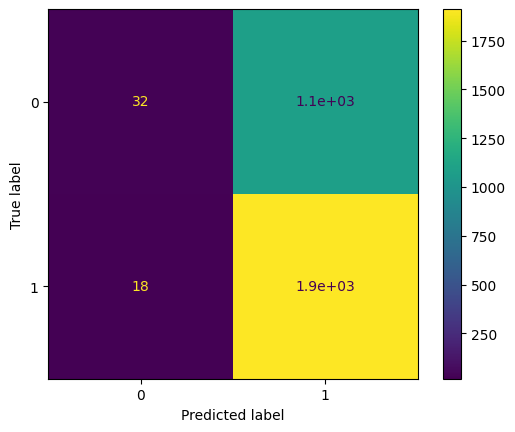

In [23]:
metrics.ConfusionMatrixDisplay(confusion_matrix=generateConfusionMatrix(results.iloc[0]), display_labels=['0', '1']).plot()

In [11]:
# Calculate fscores

def calcFScore(SP, RE):
  return 2 * (SP * RE) / (SP + RE)

results['FScore'] = results.apply(lambda row: calcFScore(row['Test_SP'], row['Test_RE']), axis=1)

results.head()

,N,nbags,exp,injuries,non-injuries,thresh,Val_AUC,Val_RE,Val_SP,Val_TP,...,Val_TN,Val_FN,Test_AUC,Test_RE,Test_SP,Test_TP,Test_FP,Test_TN,Test_FN,FScore
0,10,9,0,50,2994,0.459026,0.724415,0.64,0.638277,32,...,1911,18,0.717829,0.54,0.731797,27,803,2191,23,0.621436
1,10,9,1,50,2994,0.477397,0.740324,0.70,0.705077,35,...,2111,15,0.732953,0.60,0.788243,30,634,2360,20,0.681359
2,10,9,2,50,2994,0.461639,0.721770,0.66,0.692719,33,...,2074,17,0.730855,0.58,0.765197,29,703,2291,21,0.659850
3,10,9,3,50,2994,0.462360,0.739292,0.66,0.651303,33,...,1950,17,0.712452,0.56,0.741149,28,775,2219,22,0.637964
4,10,9,4,50,2994,0.465059,0.641256,0.60,0.608884,30,...,1823,20,0.717983,0.62,0.715097,31,853,2141,19,0.664162


In [12]:
weekResult = pd.read_csv('./week_2048/results.csv')
weekResult['Fscore'] = weekResult.apply(lambda row: calcFScore(row['Test_SP'], row['Test_RE']), axis=1)
weekResult.head()


,N,nbags,exp,injuries,non-injuries,thresh,Val_AUC,Val_RE,Val_SP,Val_TP,...,Val_TN,Val_FN,Test_AUC,Test_RE,Test_SP,Test_TP,Test_FP,Test_TN,Test_FN,Fscore
0,10,15,0,48,2967,0.466435,0.752433,0.666667,0.681496,32,...,2022,16,0.677859,0.500000,0.738793,24,775,2192,24,0.596381
1,10,15,1,48,2967,0.497091,0.768439,0.708333,0.710482,34,...,2108,14,0.674426,0.437500,0.756320,21,723,2244,27,0.554338
2,10,15,2,48,2967,0.454813,0.751432,0.666667,0.673070,32,...,1997,16,0.679664,0.520833,0.743849,25,760,2207,23,0.612678
3,10,15,3,48,2967,0.454538,0.699746,0.666667,0.665319,32,...,1974,16,0.680893,0.479167,0.707786,23,867,2100,25,0.571459
4,10,15,4,48,2967,0.476865,0.804362,0.708333,0.705426,34,...,2093,14,0.680794,0.500000,0.742838,24,763,2204,24,0.597695


In [25]:
print(weekResult.iloc[weekResult['Fscore'].idxmax()])
print(results.iloc[results['FScore'].idxmax()])

N                 10.000000
nbags             15.000000
exp                8.000000
injuries          48.000000
non-injuries    2967.000000
thresh             0.449350
Val_AUC            0.678772
Val_RE             0.604167
Val_SP             0.605999
Val_TP            29.000000
Val_FP          1169.000000
Val_TN          1798.000000
Val_FN            19.000000
Test_AUC           0.680289
Test_RE            0.625000
Test_SP            0.655544
Test_TP           30.000000
Test_FP         1022.000000
Test_TN         1945.000000
Test_FN           18.000000
Fscore             0.639908
Name: 8, dtype: float64
N                 10.000000
nbags              9.000000
exp                3.000000
injuries          50.000000
non-injuries    2994.000000
thresh             0.428572
Val_AUC            0.733507
Val_RE             0.640000
Val_SP             0.636273
Val_TP            32.000000
Val_FP          1089.000000
Val_TN          1905.000000
Val_FN            18.000000
Test_AUC           0.735

In [ ]:
# we want to pick the model with a high recall value, ie of all injuries, we want to predict as many as possible
# we also want to avoid 

In [28]:
day_res = pd.read_csv('./day_2048/results.csv')
day_res[['Test_SP', 'Test_RE', 'Test_AUC', 'thresh']].describe()

,Test_SP,Test_RE,Test_AUC,thresh
count,5.000000,5.000000,5.000000,5.000000
mean,0.746025,0.564000,0.731797,0.444582
std,0.026217,0.071274,0.002595,0.017057
min,0.719105,0.460000,0.728323,0.429418
25%,0.731797,0.520000,0.730762,0.433203
50%,0.737475,0.600000,0.731570,0.434494
75%,0.754843,0.620000,0.733039,0.458923
max,0.786907,0.620000,0.735291,0.466873


In [29]:
week_res = pd.read_csv('./week_2048/results.csv')
week_res[['Test_SP', 'Test_RE', 'Test_AUC', 'thresh']].describe()

,Test_SP,Test_RE,Test_AUC,thresh
count,5.000000,5.000000,5.000000,5.000000
mean,0.723492,0.545833,0.680720,0.462914
std,0.016999,0.045166,0.006364,0.008526
min,0.698686,0.479167,0.672733,0.448955
25%,0.717223,0.541667,0.675037,0.461379
50%,0.723964,0.541667,0.683736,0.465242
75%,0.734749,0.562500,0.685885,0.468631
max,0.742838,0.604167,0.686208,0.470360
